In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
!pip install backtesting
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173913 sha256=4e3abadf24fcebb6cb799d01568dde32384851c99e15690c56643a8cc20da117
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [2]:
df = pd.read_csv('btc_1h_processed.csv')
df.head()

,open,high,low,close,volume,ma7,ma21,rsi,%d,w%r,upper,lower,vwap,ema_f,ema_s,macd,macd_signal,return,target_cls
0,13715.65,13715.65,13400.01,13529.01,443.356199,13529.010000,13529.010000,NaN,40.869345,-59.130655,NaN,NaN,13529.010000,13529.010000,13529.010000,0.000000,0.000000,-0.024093,0
1,13528.99,13595.89,13155.38,13203.06,383.697006,13366.035000,13366.035000,0.000000,24.689764,-91.489817,NaN,NaN,13377.791144,13354.393929,13359.766731,-5.372802,-2.984890,0.009628,1
2,13203.00,13418.43,13200.00,13330.18,429.064572,13354.083333,13354.083333,28.057475,26.859590,-68.800757,NaN,NaN,13361.528135,13345.144126,13349.136506,-3.992380,-3.397796,0.005990,1
3,13330.26,13611.27,13290.00,13410.03,420.087030,13368.070000,13368.070000,38.836974,28.386909,-54.548700,NaN,NaN,13373.683573,13364.994545,13366.159666,-1.165121,-2.641470,0.014242,1
4,13434.98,13623.29,13322.15,13601.01,340.807329,13414.658000,13414.658000,54.973063,52.062993,-20.461563,NaN,NaN,13412.094107,13426.570616,13420.622427,5.948189,-0.086240,-0.003089,0


In [3]:
df.dropna(inplace=True)

In [8]:
df['Open']=df['open']
df['High']=df['high']
df['Low']=df['low']
df['Close']=df['close']
df['Volume']=df['volume']
df.drop(columns=['open','high','low','close','volume'],inplace=True)

In [66]:
sharpe=np.sqrt(252)*df['return'].mean()/df['return'].std()
ann_vol=np.sqrt(252)*df['return'].std()

In [67]:
print(sharpe,ann_vol)

0.12157430838128941 0.13837866213620403


In [9]:

df.dropna(inplace=True)
df.head()

,ma7,ma21,rsi,%d,w%r,upper,lower,vwap,ema_f,ema_s,macd,macd_signal,return,target_cls,ATR,Open,High,Low,Close,Volume
19,13127.251429,13347.688500,41.616146,35.792117,-54.108839,13807.723315,12887.653685,13325.517235,13235.846840,13284.368785,-48.521945,-36.248759,0.011999,1,184.040000,13135.00,13290.65,13106.61,13240.37,252.004885
20,13181.857143,13350.143333,39.628874,47.560089,-39.241028,13794.071587,12888.328413,13329.495998,13258.767944,13294.987166,-36.219222,-36.242797,0.006103,1,217.005000,13222.03,13472.00,13222.03,13399.24,412.026868
21,13220.374286,13347.857619,47.386741,60.282089,-25.803865,13807.178436,12903.016564,13335.717700,13289.729346,13311.872540,-22.143194,-33.401914,-0.002152,0,211.286667,13399.23,13580.67,13380.82,13481.01,326.923135
22,13249.660000,13359.711905,48.561459,70.419818,-23.695652,13815.134654,12907.242346,13339.985078,13312.201503,13324.383089,-12.181586,-29.132647,-0.005352,0,195.650000,13494.99,13599.70,13450.96,13452.00,303.301385
23,13301.374286,13362.084286,42.699059,73.296619,-30.610626,13813.151342,12906.222658,13341.589494,13321.542495,13329.274183,-7.731688,-24.832147,0.027654,1,185.518000,13455.24,13500.00,13355.01,13380.00,345.218495


In [10]:
def ATR(data, period=14):
    high = data['High']
    low = data['Low']
    close = data['Close']
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = true_range.ewm(span=period, adjust=False).mean()
    return atr

In [11]:
df['atr']=ATR(df)

In [34]:
split=0.8
split_row = int(split*len(df))
train_df = df[:split_row]
test_df = df[split_row:]

In [26]:
train_df.head()

,ma7,ma21,rsi,%d,w%r,upper,lower,vwap,ema_f,ema_s,...,macd_signal,return,target_cls,ATR,Open,High,Low,Close,Volume,atr
19,13127.251429,13347.688500,41.616146,35.792117,-54.108839,13807.723315,12887.653685,13325.517235,13235.846840,13284.368785,...,-36.248759,0.011999,1,184.040000,13135.00,13290.65,13106.61,13240.37,252.004885,184.040000
20,13181.857143,13350.143333,39.628874,47.560089,-39.241028,13794.071587,12888.328413,13329.495998,13258.767944,13294.987166,...,-36.242797,0.006103,1,217.005000,13222.03,13472.00,13222.03,13399.24,412.026868,192.830667
21,13220.374286,13347.857619,47.386741,60.282089,-25.803865,13807.178436,12903.016564,13335.717700,13289.729346,13311.872540,...,-33.401914,-0.002152,0,211.286667,13399.23,13580.67,13380.82,13481.01,326.923135,193.766578
22,13249.660000,13359.711905,48.561459,70.419818,-23.695652,13815.134654,12907.242346,13339.985078,13312.201503,13324.383089,...,-29.132647,-0.005352,0,195.650000,13494.99,13599.70,13450.96,13452.00,303.301385,187.763034
23,13301.374286,13362.084286,42.699059,73.296619,-30.610626,13813.151342,12906.222658,13341.589494,13321.542495,13329.274183,...,-24.832147,0.027654,1,185.518000,13455.24,13500.00,13355.01,13380.00,345.218495,182.059963


In [53]:
x_train=train_df.drop(columns=['target_cls','return'],axis=1)
y_train=train_df['target_cls']
x_test=test_df.drop(columns=['target_cls','return'],axis=1)
y_test=test_df['target_cls']

In [38]:
clf=RandomForestClassifier(max_depth=7,min_samples_leaf=2,min_samples_split=10,random_state=42)
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

In [39]:
accuracy

0.5333146303829429

In [43]:
print(x_test.head())
x_test.shape

                ma7          ma21        rsi         %d        w%r  \
28534  56907.480000  56553.746190  63.920021  67.718445  -4.521013   
28535  56952.041429  56594.245238  73.226126  75.351401 -13.564700   
28536  57046.705714  56672.236667  71.195268  89.615966 -13.066389   
28537  57171.718571  56763.141429  71.242030  88.320915  -8.406165   
28538  57321.177143  56837.838571  70.320950  87.514179 -15.984910   

              upper         lower          vwap         ema_f         ema_s  \
28534  57387.013317  55717.109683  13941.012989  56791.679565  56843.160291   
28535  57509.766242  55733.094758  13943.006915  56877.844956  56887.216565   
28536  57646.289782  55779.494218  13944.990394  56985.913629  56946.560524   
28537  57799.801282  55787.412718  13946.311858  57090.209145  57007.417522   
28538  57920.335193  55814.126807  13947.861176  57174.510592  57060.384372   

             macd  macd_signal         ATR      Open      High       Low  \
28534  -51.480726  -139.7508

(7129, 19)

In [44]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(precision, recall)

0.5261437908496732 0.6770395290159799


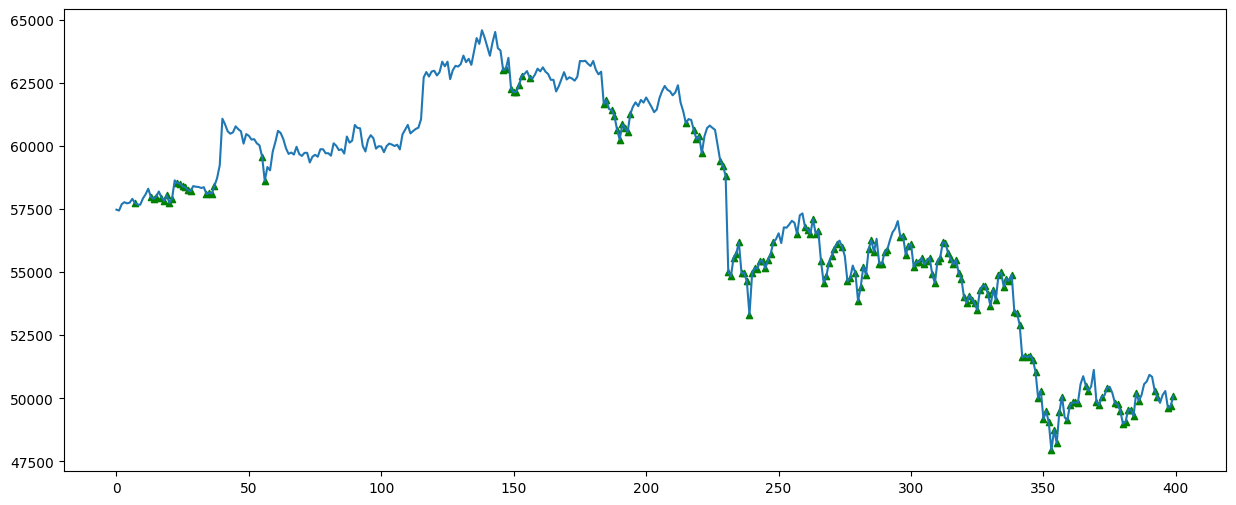

In [51]:
X_test=x_test[:400]
X_TEST=x_test[:2500]
plt.figure(figsize=(15, 6))
close_prices = X_test['Close'].values
x_axis = np.arange(len(close_prices))
buy=(y_pred[:400]==1)
sell=(y_pred[:400]==0)
plt.plot(x_axis,close_prices)
plt.scatter(x_axis[buy],close_prices[buy], color='green', label='Buy Signal',marker='^', s=20)
#plt.scatter(x_axis[sell],close_prices[sell], color='red', label='Sell Signal',marker='v', s=20)

In [52]:
def predict(model,X):
  return pd.Series(model.predict(X))
def price(df):
    return df.Close

(2500, 19)

In [59]:
class Strat(Strategy):
    model=clf
    X=X_TEST
    sl=1
    tp=2
    def init(self):
        self.y=self.I(predict,self.model,self.X)
        self.pr=self.I(price,self.X)
        self.ATR=self.I(ATR,self.X)
    def next(self):
        prev_wr=x_test['w%r'].iloc[-2]
        cur_wr = x_test['w%r'].iloc[-1]
        macd_line = x_test['macd'].iloc[-1]
        signal_line =x_test['macd_signal'].iloc[-1]
        p=self.pr[-1]
        atr=self.ATR[-1]
        slt= int(self.sl)
        tpt= int(self.tp)
        if prev_wr>-50 and cur_wr<-50 and macd_line>signal_line and (self.y==1):
            self.buy(sl=p-slt*atr, tp=p+tpt*atr)

        elif prev_wr<-50 and cur_wr>-50 and macd_line<signal_line and (self.y==0):
            self.sell()

bt=Backtest(X_TEST, Strat, cash=100_000, commission=0.0005)
stats=bt.run()
stats

/usr/local/lib/python3.10/dist-packages/backtesting/backtesting.py:1054: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  (data.index.is_numeric() and
<ipython-input-59-370eb3947d49>:25: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt=Backtest(X_TEST, Strat, cash=100_000, commission=0.0005)


,0
Start,28534.0
End,31033.0
Duration,2499.0
Exposure Time [%],99.92
Equity Final [$],148535.301705
Equity Peak [$],159880.59749
Return [%],48.535302
Buy & Hold Return [%],-44.674189
Return (Ann.) [%],0.0
Volatility (Ann.) [%],NaN


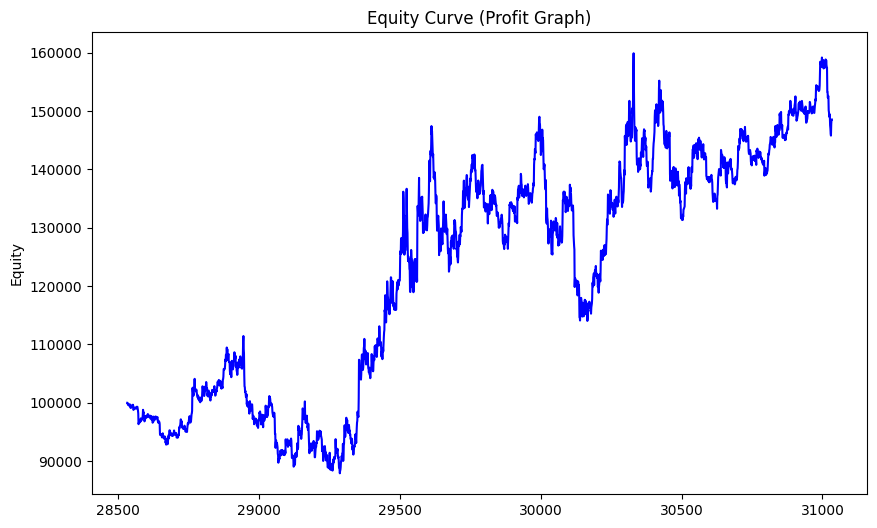

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(stats['_equity_curve']['Equity'], label='Equity Curve', color='blue')
plt.title('Equity Curve (Profit Graph)')
plt.ylabel('Equity')
plt.show()